# Phalanx Touch classification using Convolutional Neural Network (KERAS)

Using state of the art convolutional neural networks techniques, we trained our model to classify between Finger and Phalanx touches. We provided training data file consisting data from all participants as input. Later splitting data in to 80% - 20% as training and test set (20:5) participant wise. This will ensure that samples from the same participant won't fall in both training and test set.We used SGD as optimizer with learning rate (0.01). Our CNN Model acheived test accuracy of 98.17 %. 

This code is based on example of Convolutional Neural Network (https://www.kaggle.com/poojachiluvuri/cnn-for-mnist-using-keras, https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).


In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
# config = tf.ConfigProto(device_count = {"GPU": 0})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.7

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [3]:
df = pd.read_pickle('DataSet_Phalanx/04_Training_Set/trainingdata.pkl')
df['Label'] = df['Label'].replace({'finger': 0,'phalanx': 1})
pids= df.Participant.unique()
pidsTrain = pids[:(int)(len(pids)*0.8)]
pidsTest = pids[(int)(len(pids)*0.8):]
print(pids)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]


In [4]:
train = df[df.Participant.isin(pidsTrain)]
test = df[df.Participant.isin(pidsTest)]

In [5]:
%%time
x_train = train.Input
y_train = train.Label
x_test  = test.Input
y_test  = test.Label

x_train = np.rollaxis(np.dstack(x_train.values),-1)
x_test = np.rollaxis(np.dstack(x_test.values),-1)


CPU times: user 12 s, sys: 1.94 s, total: 14 s
Wall time: 13.8 s


In [6]:
# input image dimensions
img_rows, img_cols = 27, 15
size = df.shape[0]

In [7]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [8]:
x_train.shape

(1431907, 27, 15, 1)

In [9]:
%%time
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (1431907, 27, 15, 1)
1431907 train samples
329415 test samples
CPU times: user 2.5 s, sys: 1.95 s, total: 4.45 s
Wall time: 4.4 s


In [10]:
# Setting up parameters for Model.
batch_size = 256
num_classes = 2
epochs = 50


In [11]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [12]:
input_shape

(27, 15, 1)

In [13]:
%%time 

model = Sequential()

#This applies 64 convolution filters of size 2X2 and 3X3 in respective layers.
model.add(Conv2D(64, (2, 2), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform()))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform()))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

#adagrad = keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
#rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
sgd = keras.optimizers.sgd(lr=0.01, decay=1e-6, momentum=0.6, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd,metrics=['accuracy'])
model.summary()
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,verbose=1,validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 14, 64)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 6, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 6, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 4, 128)        73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 2, 128)         147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 1, 128)         0         
__________

In [14]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.05418027347178845
Test accuracy: 0.9814944674652326


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


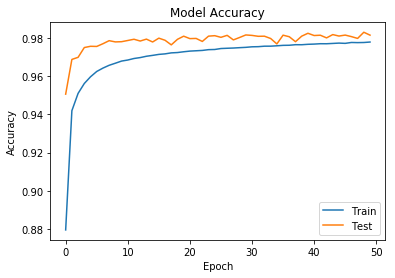

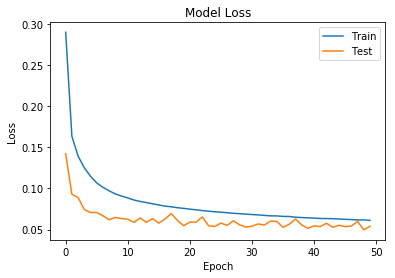

In [15]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [17]:
#Saving Model as HDF5 file.
model.save("CNN_Models/model_with_orientation2.h5")